In [1]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns   

import leidenalg

In [3]:
adata_endo = sc.read_h5ad('/home/yike/phd/dataset_from_google/Tabula_Sapiens_Single_Cell_Dataset/TS_Endothelial.h5ad')

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.3 scipy==1.6.1 pandas==1.1.4 scikit-learn==0.22 statsmodels==0.12.2 python-igraph==0.9.0 louvain==0.7.0


In [4]:
adata_endo

AnnData object with n_obs × n_vars = 11973 × 58833
    obs: 'Annotation', 'Predictability', 'Manually Annotated', 'Donor', 'Method', 'Organ', 'Compartment', 'Anatomical Information'
    var: 'gene_symbol', 'ensembl_id', 'gene_length'
    uns: 'Compartment_colors', 'Donor_colors', 'Manually Annotated_colors', 'Method_colors', 'Organ_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    layers: 'counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata_endo.var_names_make_unique()

In [6]:
sc.pp.filter_cells(adata_endo, min_genes=200)
sc.pp.filter_genes(adata_endo, min_cells=3)

filtered out 23496 genes that are detected in less than 3 cells


In [7]:
sc.pp.normalize_total(adata_endo, target_sum=1e6)
# Total-count normalize (library-size correct) the data matrix X to 10, 000 reads per cell,
# so that counts become comparable among cells

sc.pp.log1p(adata_endo)
# Logarithmize the data
print('Number of genes: {:d}'.format(adata_endo.n_vars))

normalizing counts per cell
    finished (0:00:00)


Number of genes: 35337


In [9]:
bad_genes = adata_endo.var_names.str.startswith(('RPS', 'RPL', 'MT', 'HLA', 'MRPS', 'MRPL')) 
good_genes = ~ bad_genes
adata_endo = adata_endo[:, good_genes]
print('Number of genes after cell filter: {:d}'.format(adata_endo.n_vars))

Number of genes after cell filter: 34157


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


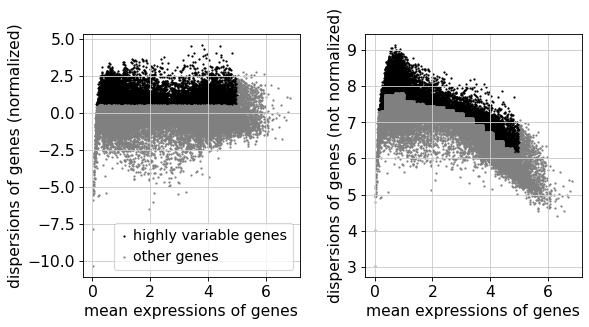

get 8690 highly variable cells


In [13]:
sc.pp.highly_variable_genes(adata_endo, min_mean=0.125, max_mean=5, min_disp=0.5)
sc.pl.highly_variable_genes(adata_endo)
print('get {:d} highly variable cells'.format(adata_endo.var.highly_variable.sum()))

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


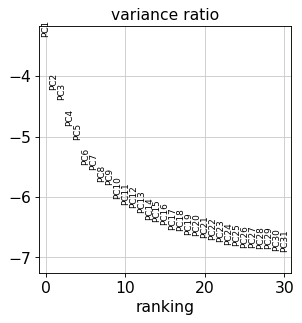

In [14]:
sc.tl.pca(adata_endo, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_endo, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


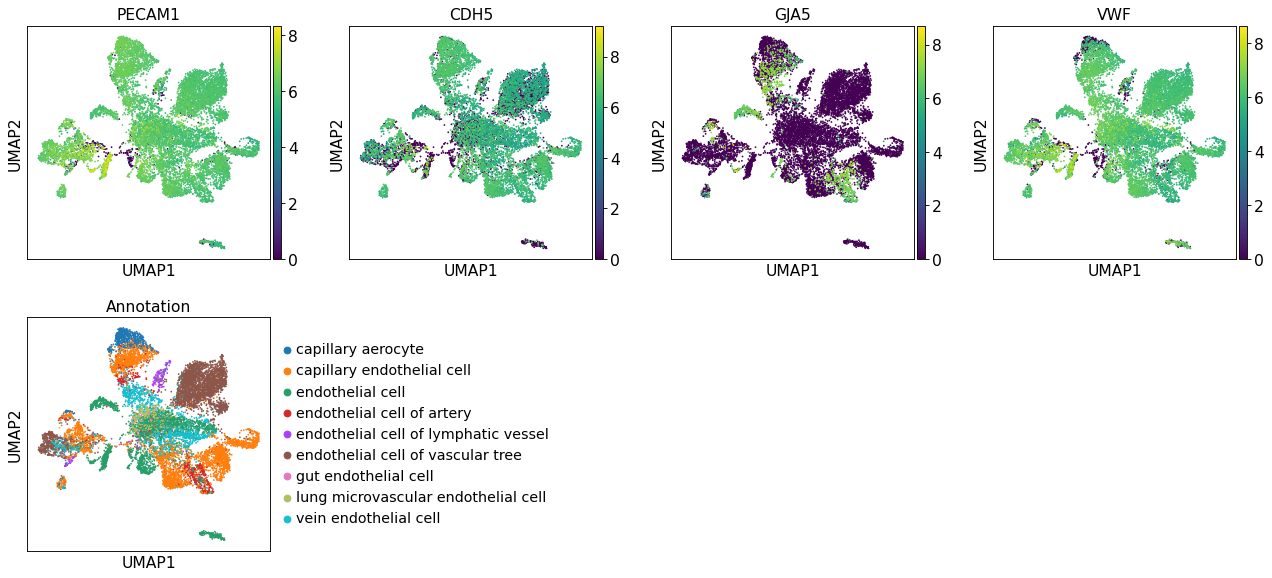

In [15]:
sc.pp.neighbors(adata_endo, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_endo)
sc.pl.umap(adata_endo, color=['PECAM1', 'CDH5', 'GJA5', 'VWF', 'Annotation', ])

In [31]:
(adata_endo[:, 'PECAM1'].X > 0).mean(axis=0)

matrix([[0.9575712]])

In [70]:
sc.tl.leiden(adata_endo, resolution=0.0001, partition_type=leidenalg.CPMVertexPartition, key_added='leiden_0.0001')

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.0001', the cluster labels (adata.obs, categorical) (0:00:00)


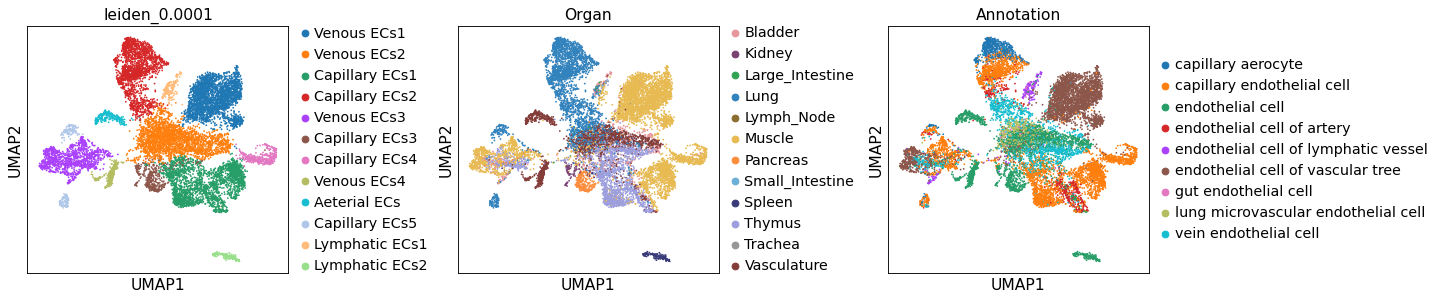

In [82]:
sc.pl.umap(adata_endo, color=['leiden_0.0001', 'Organ', 'Annotation'], wspace=0.5)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:53)


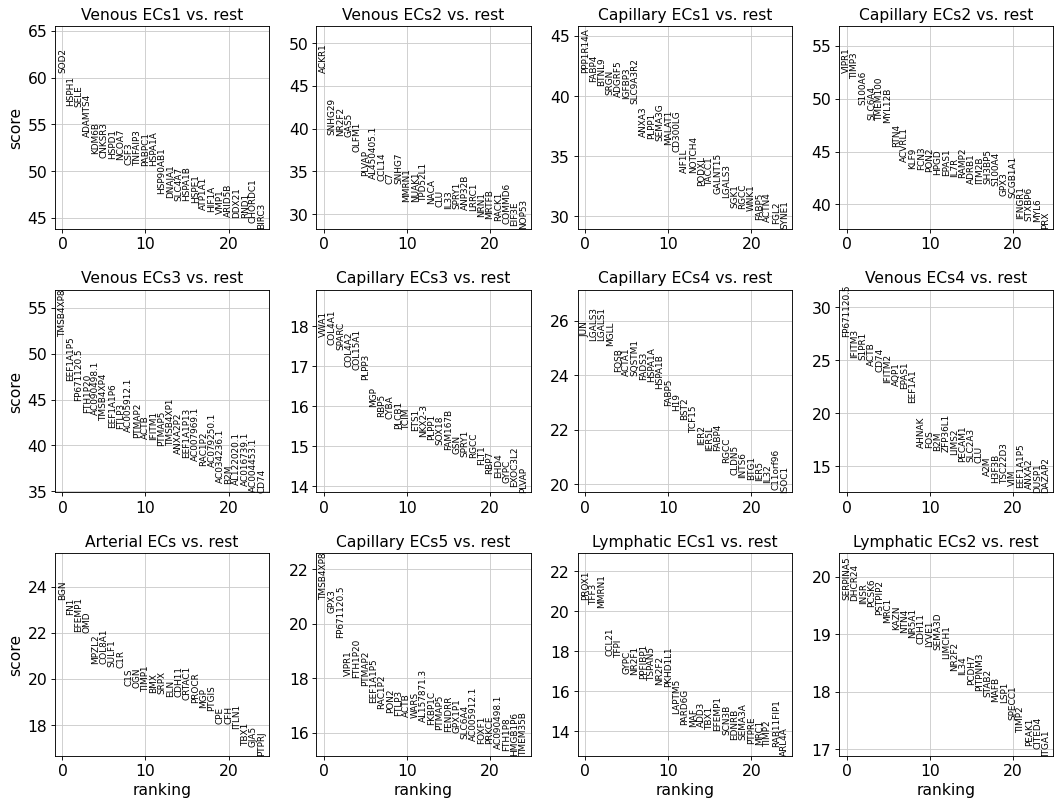

In [99]:
sc.tl.rank_genes_groups(adata_endo, 'leiden_0.0001', method='wilcoxon')
sc.pl.rank_genes_groups(adata_endo, n_genes=25, sharey=False)

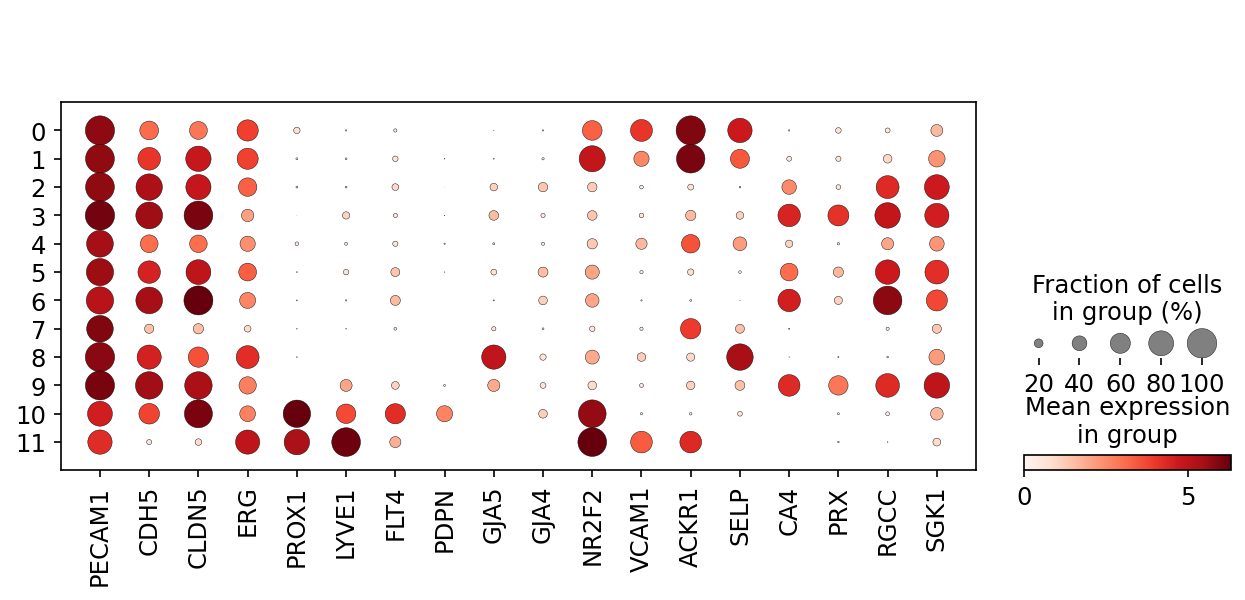

In [78]:
# Integrated Single-Cell Atlas of Endothelial Cells of the Human Lung
# marker_genes = ['PECAM1', 'CDH5', 'CLDN5', 'ERG', # canonical endothelial markers
#                 'PROX1', 'LYVE1', 'FLT4', 'PDPN',  # lymphatic ECs
#                 'EFNB2', 'SOX17', 'BMX', 'SEMA3G', 'HEY1', 'LTBP4', 'FBLN5', 'GJA5', 'GJA4', # arterial ECs
#                 'NR2F2', 'VCAM1', 'ACKR1', 'SELP',  # venous ECs
#                 'CA4', 'PRX', 'RGCC', 'SGK1', # capillary ECs
#                 ]

marker_genes = ['PECAM1', 'CDH5', 'CLDN5', 'ERG', # canonical endothelial markers
                'PROX1', 'LYVE1', 'FLT4', 'PDPN',  # lymphatic ECs
                'GJA5', 'GJA4', # arterial ECs
                'NR2F2', 'VCAM1', 'ACKR1', 'SELP',  # venous ECs
                'CA4', 'PRX', 'RGCC', 'SGK1', # capillary ECs
                ]

fig,ax = plt.subplots(figsize=[10, 4], dpi=150)
sc.pl.dotplot(adata_endo, marker_genes, groupby='leiden_0.0001', use_raw=False, ax=ax)

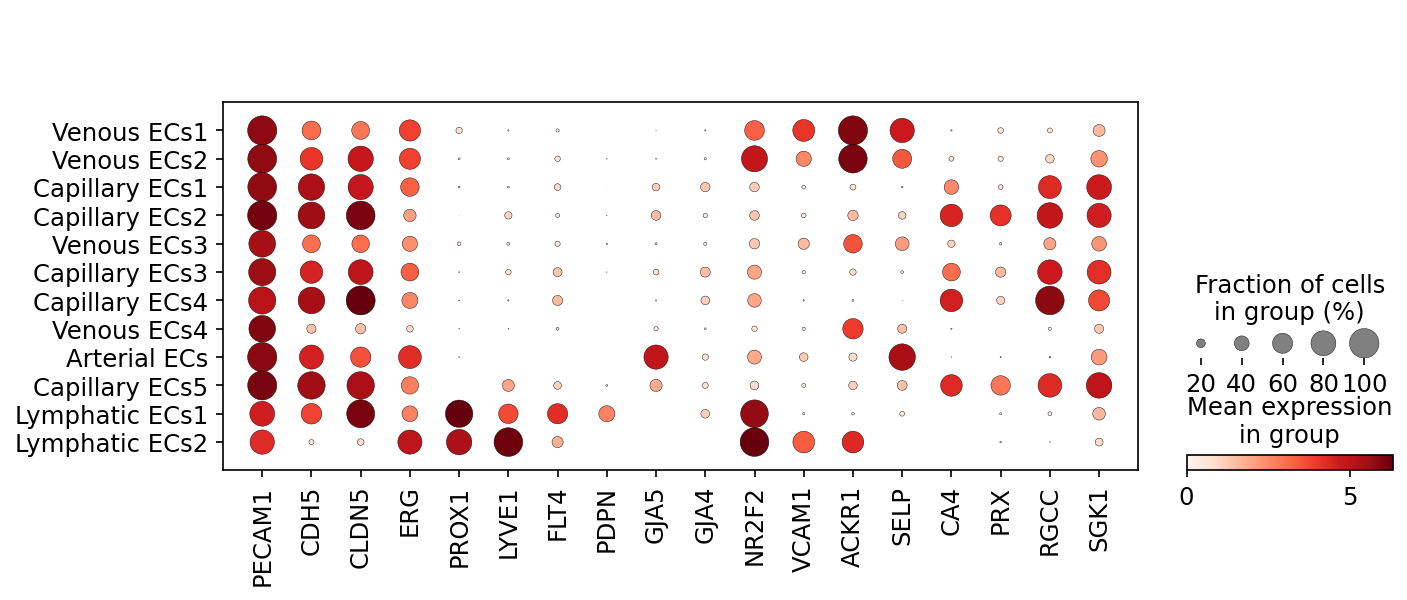

In [138]:
fig,ax = plt.subplots(figsize=[10, 4], dpi=150)
sc.pl.dotplot(adata_endo, marker_genes, groupby='leiden_0.0001', use_raw=False, ax=ax)

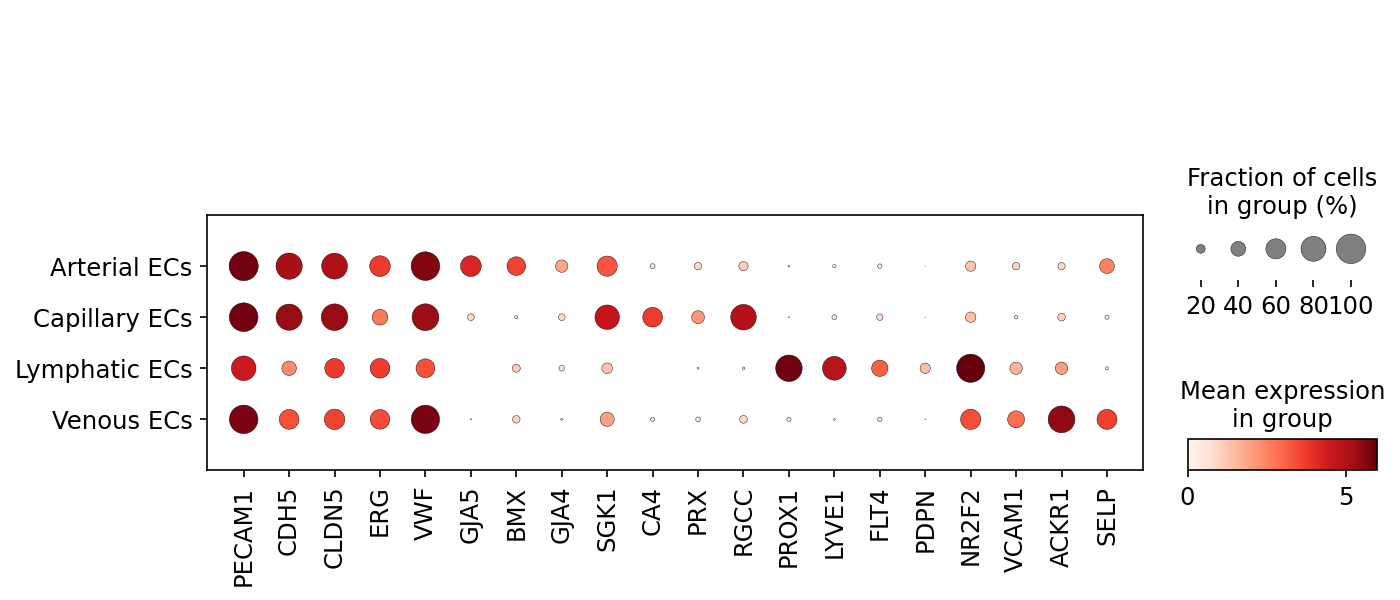

In [151]:
marker_genes = ['PECAM1', 'CDH5', 'CLDN5', 'ERG', 'VWF', # canonical endothelial markers
                'GJA5', 'BMX', 'GJA4', # arterial ECs
                'SGK1', 'CA4', 'PRX', 'RGCC', # capillary ECs
                'PROX1', 'LYVE1', 'FLT4', 'PDPN',  # lymphatic ECs
                'NR2F2', 'VCAM1', 'ACKR1', 'SELP',  # venous ECs
                ]

fig,ax = plt.subplots(figsize=[10, 4], dpi=150)
sc.pl.dotplot(adata_endo, marker_genes, groupby='cell_subtype', use_raw=False, ax=ax)

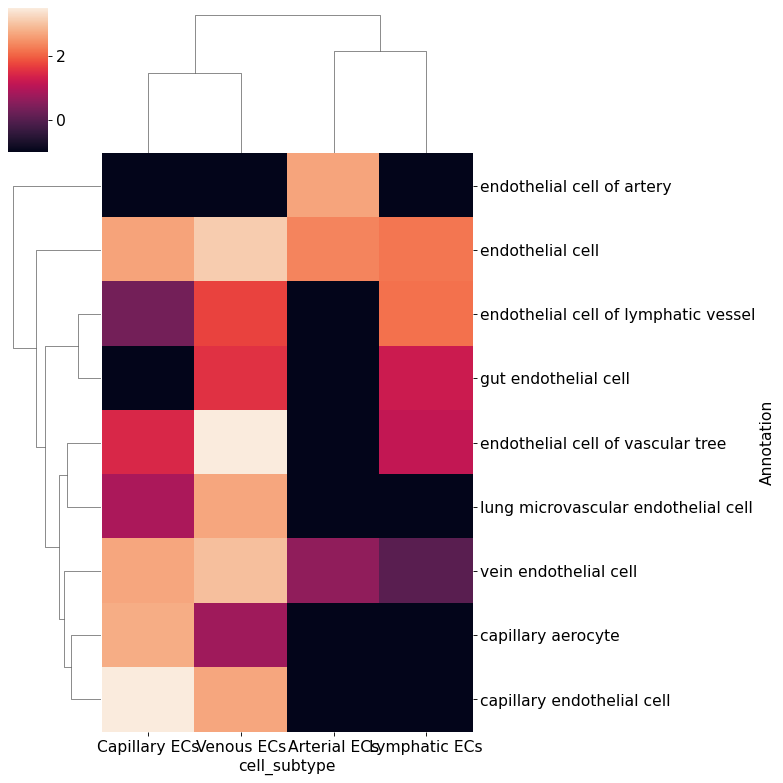

In [143]:
a = adata_endo.obs.groupby(['Annotation', 'cell_subtype']).size().unstack(fill_value=0)
sns.clustermap(np.log10(a+0.1))

In [95]:
# Annotate 'leiden_0.0001'

cluster_ID = {0: 'Venous ECs1',
              1: 'Venous ECs2',
              2: 'Capillary ECs1',
              3: 'Capillary ECs2',
              4: 'Venous ECs3',
              5: 'Capillary ECs3',
              6: 'Capillary ECs4',
              7: 'Venous ECs4',
              8: 'Arterial ECs',
              9: 'Capillary ECs5',
              10: 'Lymphatic ECs1',
              11: 'Lymphatic ECs2',
             }
cluster_name = cluster_ID.values()

adata_endo.rename_categories('leiden_0.0001', cluster_name)

adata_endo.obs['cell_subtype'] = adata_endo.obs['leiden_0.0001'].replace({
    'Venous ECs1': 'Venous ECs', 
    'Venous ECs2': 'Venous ECs', 
    'Capillary ECs1': 'Capillary ECs', 
    'Capillary ECs2': 'Capillary ECs', 
    'Venous ECs3': 'Venous ECs', 
    'Capillary ECs3': 'Capillary ECs', 
    'Lymphatic ECs1': 'Lymphatic ECs', 
    'Lymphatic ECs2': 'Lymphatic ECs',
    'Capillary ECs4': 'Capillary ECs', 
    'Venous ECs4': 'Venous ECs', 
    'Capillary ECs5': 'Capillary ECs', 
})

In [131]:
# According to expression of 'GJA5' in UMAP, name 'endothelial cell of artery' from 'Annotation' as 'Arterial ECs' in 'Cell_subtype'
adata_endo.obs.loc[adata_endo.obs['Annotation'] == 'endothelial cell of artery', 'cell_subtype'] = 'Arterial ECs'

In [ ]:
adata_endo.write('/home/yike/phd/dataset_from_google/Tabula_Sapiens_Single_Cell_Dataset/TS_Endothelial_reculster.h5ad')

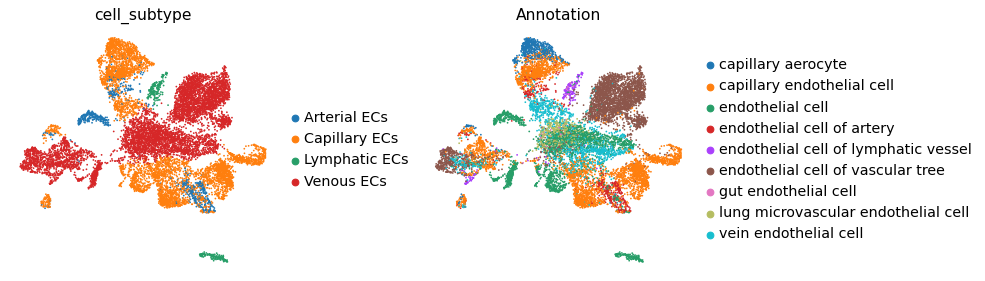

In [128]:
sc.pl.umap(adata_endo, color=['cell_subtype', 'Annotation'], frameon=False, wspace=0.4)

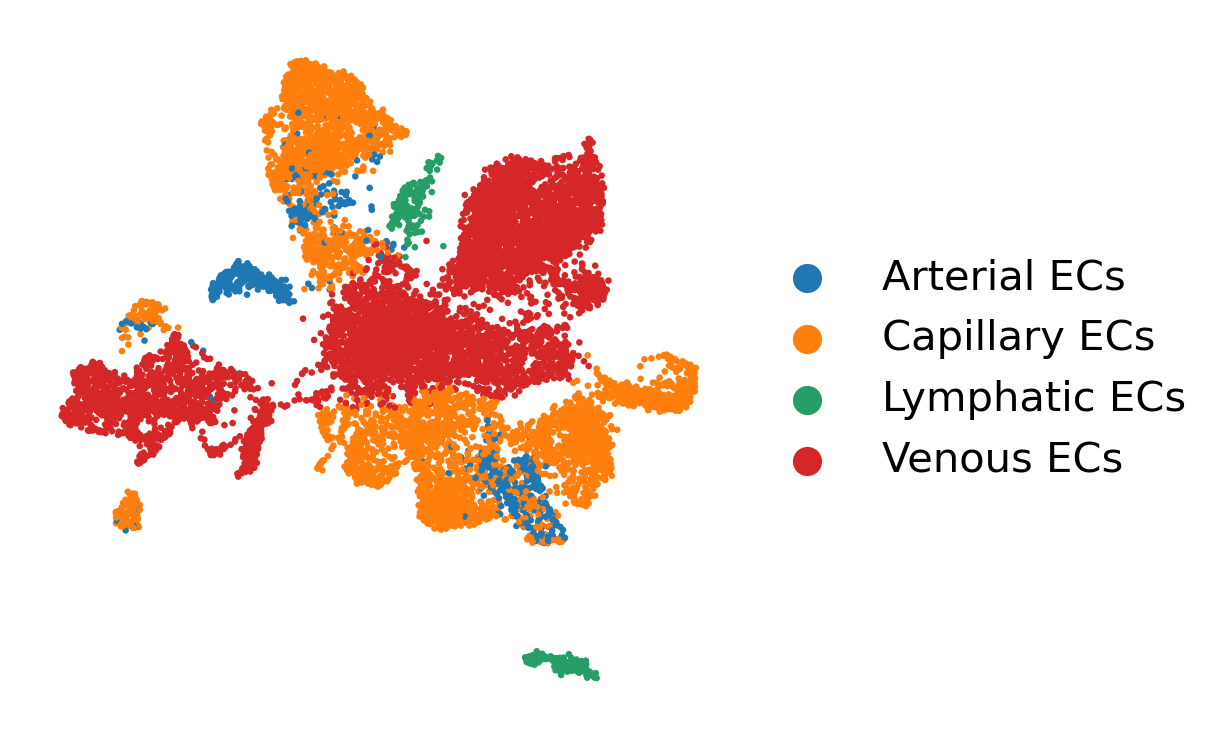

In [11]:
fig, ax = plt.subplots(figsize=[3, 3], dpi=300, facecolor='white')
sc.pl.umap(adata_endo, color=['cell_subtype'], frameon=False, wspace=0.4, ax=ax, title='')